In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 219107776'

In [2]:
lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=5)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   219107776      0.0
  1 TESS Sector 15 2019   SPOC     120   219107776      0.0
  2 TESS Sector 16 2019   SPOC     120   219107776      0.0
  3 TESS Sector 17 2019   SPOC     120   219107776      0.0
  4 TESS Sector 18 2019   SPOC     120   219107776      0.0


Gaps at times: [1696.38854348]
Gaps at times: [1721.58580465]
Gaps at times: [1748.68724642]
Gaps at times: [1773.58173744]
Gaps at times: [1791.10954097 1800.4581543 ]


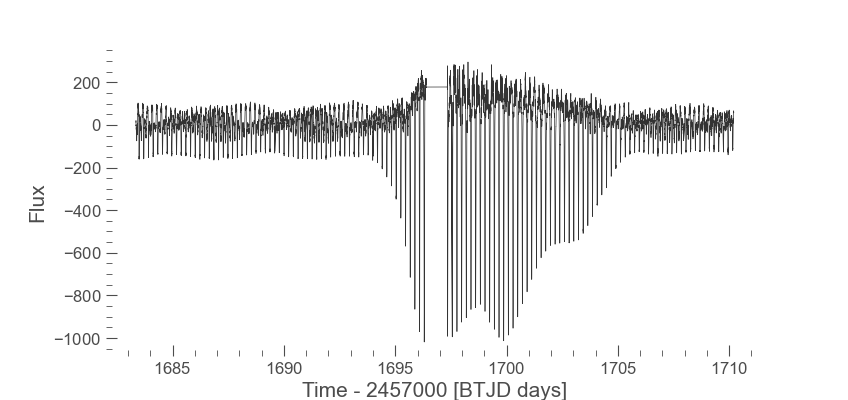

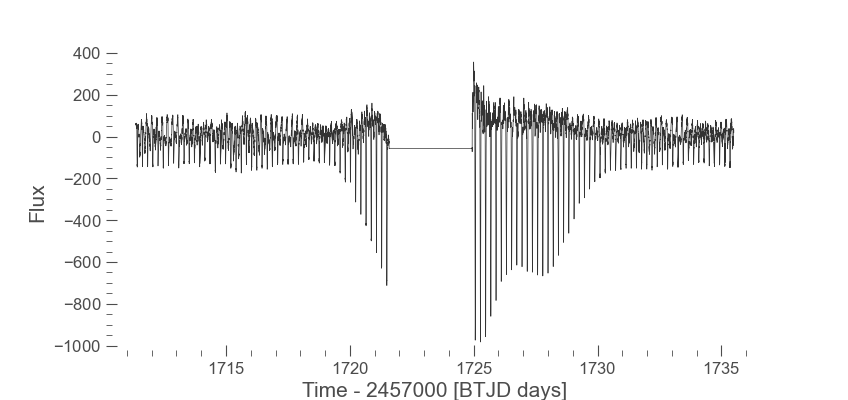

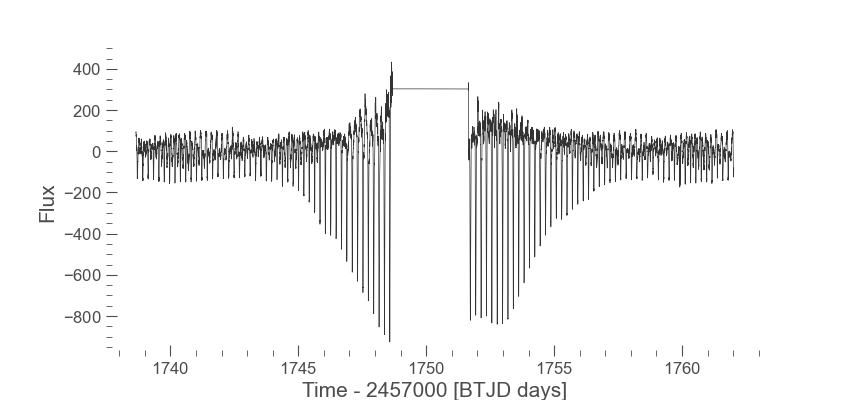

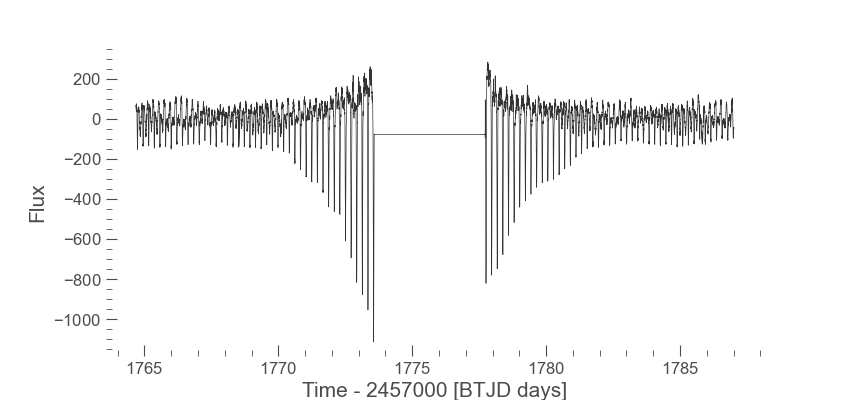

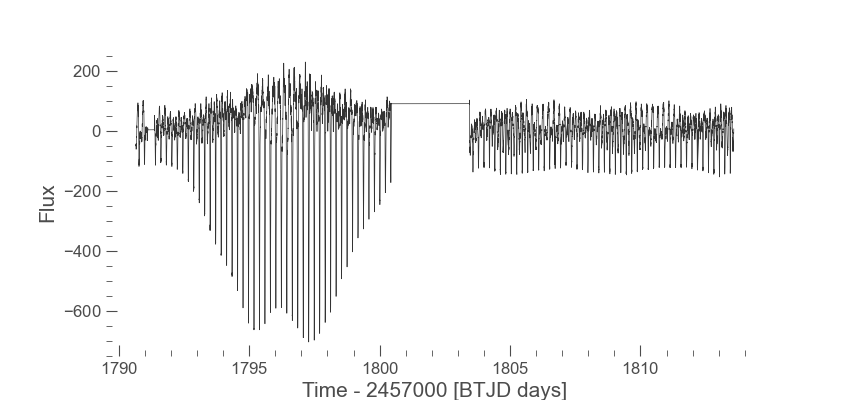

In [3]:
new_lcs = []

for lc in lcs:
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=1500)
    new_lc = straight_lines(new_lc, cadence_magnifier= 20)
    new_lcs.append(new_lc)
    new_lc.plot()

In [4]:
lightcurve = combine_lightcurves(new_lcs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704140 entries, 0 to 1704139
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    float64
 1   flux    float64
dtypes: float64(2)
memory usage: 26.0 MB
None
Index         132
time     13633120
flux     13633120
dtype: int64


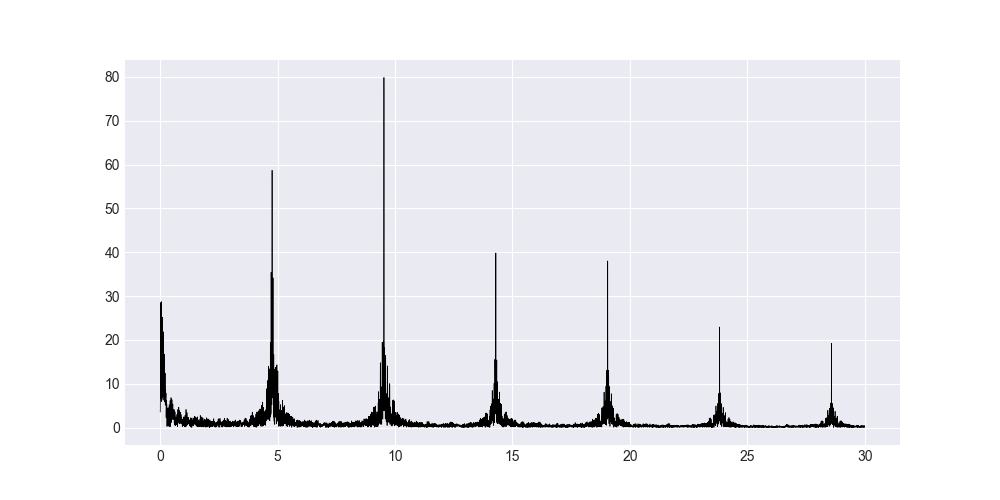

In [5]:
import matplotlib.widgets as widgets

periodogram = lightcurve.to_periodogram(maximum_frequency = 30)

f = periodogram.frequency.value
p = periodogram.power.value

plt.figure(figsize=(10, 5))
periodogram_plot = plt.plot(f, p, 'k', lw=0.5)
plt.show()

# px.line(x=f, y=p, color_discrete_sequence=['black']).show()



In [6]:
widgets.AxesWidget(periodogram_plot[0])

2121
[   12    24    36 ... 19511 19522 19528]
[1.99654157e-02 3.83950302e-02 5.68246447e-02 ... 2.99665532e+01
 2.99834470e+01 2.99926618e+01]


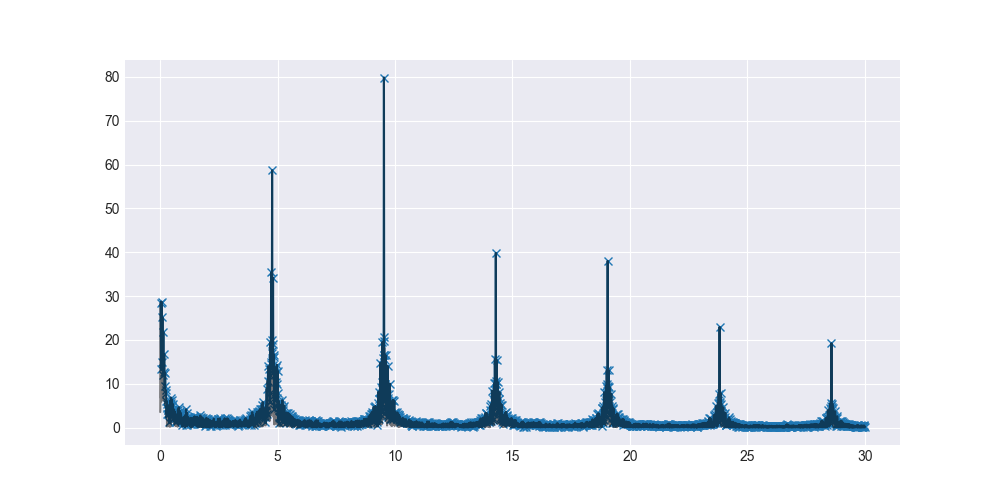

KeyError: 'peak_heights'

In [7]:
frequencies = periodogram.frequency.value
power = periodogram.power.value

pd.DataFrame({'frequencies': frequencies, 'power': power})

peaks, pdict = signal.find_peaks(power)

print(len(peaks))

print(peaks)

print(frequencies[peaks])

plt.figure(figsize=(10, 5))
plt.plot(frequencies[peaks], power[peaks], marker='x')
plt.plot(frequencies, power, alpha=0.5, color='black')
plt.show()


1/(lightcurve.time.btjd[-1] - lightcurve.time.btjd[0])

initial_guess = [pdict['peak_heights'][0], frequencies[peaks][0], 0.5/(lightcurve.time.btjd[-1] - lightcurve.time.btjd[0])]

optimized_parameters, covariance = optimize.curve_fit(gaussian, frequencies, power, p0=initial_guess)

amp, cen, wid = optimized_parameters

f = np.linspace(frequencies.min(), frequencies.max(), 1000000)

fitted_gaussian = gaussian(f, amp, cen, wid)

another_gaussian = gaussian(f, pdict['peak_heights'][0], frequencies[peaks][0], 0.5/(lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]))

plt.figure(figsize=(10, 5))
plt.plot(frequencies, power, label='Periodogram', marker='o', markersize=1, alpha=0.5, color='black')
plt.plot(f, fitted_gaussian, label='Fitted Gaussian', color='red')
plt.plot(f, another_gaussian, label='Another Gaussian', color='blue')
plt.plot(f, p, label='Spline', color='green')
plt.plot(f, nother_gaussian, label='Another Fitted Gaussian', color='purple')

print(f'Amplitude: {amp}')
print(f'Central Frequency: {cen}')
print(f'Standard Deviation: {wid}')


The next section here finds the period to be used for O-C calculations as well as for folding.
A gaussian curve is fit on a Periodogram that is obtained from the desired `lightcurve`.

Please click on the desired peak to make the program process data, the peak should be the tallest peak in the entire mess of principle peak.

In [ ]:
peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
max_power = periodogram.max_power.value
initial_guess_global = []

frequencies = periodogram.frequency.value
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 1000000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        initial_guess_global.append(initial_guess)
        print(initial_guess_global[-1])

        guess = initial_guess_global[-1]
        optimized_parameters, covariance = optimize.curve_fit(gaussian, frequencies, power, initial_guess_global[-1])
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)

        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color='red'))) 
    


scatter.on_click(update_point)
fi


In [ ]:
guess = initial_guess_global[-1]

optimized_parameters, covariance = optimize.curve_fit(gaussian, frequencies, power, guess)
op, cov = optimize.curve_fit(gaussian, f, p, p0=guess)
amp, cen, wid = optimized_parameters

initial_gaussian = gaussian(f, guess[0], guess[1], guess[2])
fitted_gaussian = gaussian(f, amp, cen, wid)
smooth_fit_gaussian = gaussian(f, op[0], op[1], op[2])

plt.figure()
plt.plot(frequencies, power, label='Periodogram', color='black')
plt.plot(f, initial_gaussian, label='Initial Gaussian', color='red')
plt.plot(f, fitted_gaussian, label='Fitted Gaussian', color='blue')
plt.plot(f, smooth_fit_gaussian, label='Smooth Fitted Gaussian', color='green')
plt.legend()

fi.add_trace(go.Scatter(x=f, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color='red')))




In [ ]:
t = lightcurve.time.btjd
f = lightcurve.flux

s = sine(t, 100, cen, 0.0611, -100)

ax = lightcurve.plot()
ax.plot(t, s, color='red')

In [ ]:
bin_num = 200
period = 1/cen
lightcurve.fold(period).bin(time_bin_size = period/bin_num).scatter()

In [ ]:
l = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=2)
l[0].fold(period).bin(time_bin_size = 0.0005).scatter()

In [ ]:
import plotly.graph_objects as go

import numpy as np
np.random.seed(1)

x = np.random.rand(100)
y = np.random.rand(100)

f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers')])

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 100
f.layout.hovermode = 'closest'


# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#bae2be'
        s[i] = 20
        with f.batch_update():
            scatter.marker.color = c
            scatter.marker.size = s


scatter.on_click(update_point)

f